<a href="https://colab.research.google.com/github/PaulinaHernandez/CNN-pytorch/blob/main/CNN_pytorch_emotion_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

#Dataset


Dataset - fetch the data Dataloader - batchs it and shuffle using parallel process, needs to know the len() of the dataset and getitem from an index, inside the dataloader there's a collate_fn() which arreange this data in a batch


In [41]:
# Mount Google Drive
drive.mount('/content/drive')

# Define your data directory
data_dir = "/content/drive/MyDrive/Projects/CNN-data"

# Standard Transformation for All Datasets
transform_standard = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the entire dataset without any transformation
full_dataset = datasets.ImageFolder(data_dir)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_test_dataset = random_split(full_dataset, [train_size, val_size + test_size])

# Further split val_test_dataset into validation and test sets
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Now wrap the datasets with the CustomDataset class to apply the standard transformations
train_dataset = CustomDataset(train_dataset, transform=transform_standard)
val_dataset = CustomDataset(val_dataset, transform=transform_standard)
test_dataset = CustomDataset(test_dataset, transform=transform_standard)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Explore

In [42]:
 # Assuming you've already split your datasets into train_dataset, val_dataset, and test_dataset

print(f"Length of Training Dataset: {len(train_dataset)}")
print(f"Length of Validation Dataset: {len(val_dataset)}")
print(f"Length of Test Dataset: {len(test_dataset)}")


Length of Training Dataset: 213
Length of Validation Dataset: 45
Length of Test Dataset: 47


In [43]:
print(full_dataset.class_to_idx)

{'happy': 0, 'sad': 1}


# Model

In [44]:
class EmotionCNNSequential(nn.Module):
    def __init__(self):
        super(EmotionCNNSequential, self).__init__()

        # Convolutional layers block
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers block
        self.fc_layers = nn.Sequential(
            # Adjust the input size based on your input image's dimension after pooling
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output layer: 1 unit for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 28 * 28)
        x = self.fc_layers(x)
        # No sigmoid activation here because nn.BCEWithLogitsLoss will apply it
        return x

##Check device

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [46]:
device

device(type='cpu')

#Training

In [47]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/6, Train Loss: 1.2362, Validation Loss: 0.5721
Epoch 2/6, Train Loss: 0.5201, Validation Loss: 0.5648
Epoch 3/6, Train Loss: 0.4553, Validation Loss: 0.5168
Epoch 4/6, Train Loss: 0.3645, Validation Loss: 0.4031
Epoch 5/6, Train Loss: 0.2475, Validation Loss: 0.3870
Epoch 6/6, Train Loss: 0.1450, Validation Loss: 0.4362


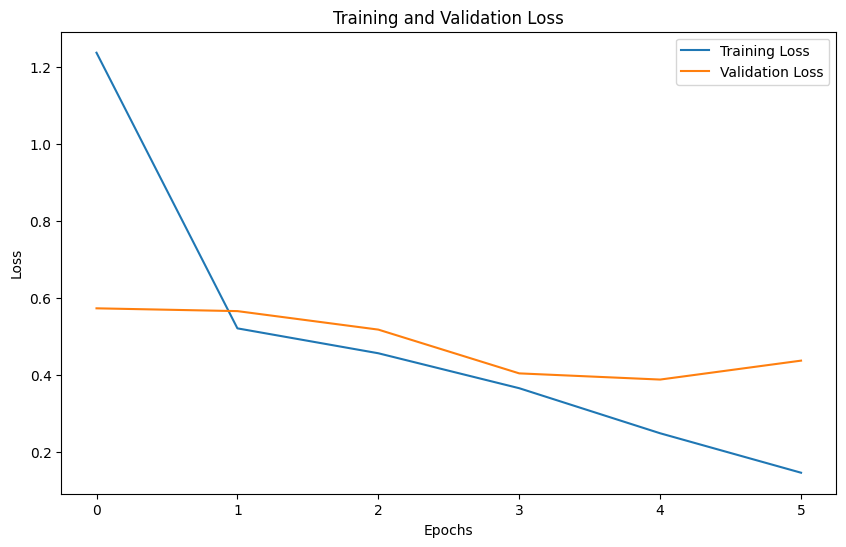

In [50]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Instantiate the model
model = EmotionCNNSequential()

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Number of epochs
num_epochs = 6

# Lists to store losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')



#Plot

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Evaluation

In [51]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            # Apply sigmoid to convert outputs to probabilities
            probs = torch.sigmoid(outputs)
            # Convert probabilities to predicted class (0 or 1) based on 0.5 threshold
            preds = probs > 0.5
            loss = criterion(outputs, labels)

            test_running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels.byte()).item()
            total_predictions += labels.size(0)

    test_loss = test_running_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / total_predictions

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Assuming your device is already defined
evaluate_model(model, test_loader, device)


Test Loss: 0.5462, Test Accuracy: 0.7447


### Let's try a new image

In [52]:
from torchvision import transforms
from PIL import Image

# Path to your new image
image_path = '/content/drive/MyDrive/Pythonclass/CNN-data/img.jpg'

# Same transformations as used for your validation/test dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming this is the size your model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open(image_path)

# Apply transformations
image = transform(image).unsqueeze(0)

In [53]:
# Assuming 'model' is your trained model and 'device' is defined (e.g., cuda or cpu)
model.eval()  # Set the model to evaluation mode
image = image.to(device)  # Move the image to the same device as your model

with torch.no_grad():  # No need to track gradients
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

# Assuming you have a list or dict of class indices to class names
class_names = ['class0', 'class1']  # Example class names
predicted_class = class_names[predicted.item()]

print(f'Predicted class: {predicted_class}')

Predicted class: class0
